# **1D 2LSTM32**


---

This is The 1D_2xLSTM32 model build and train file. when runing this file you would get at the end the saved traind model file. This model is traind using the data collected by one of us.


under this section you can find all the global variables, imports and settings.

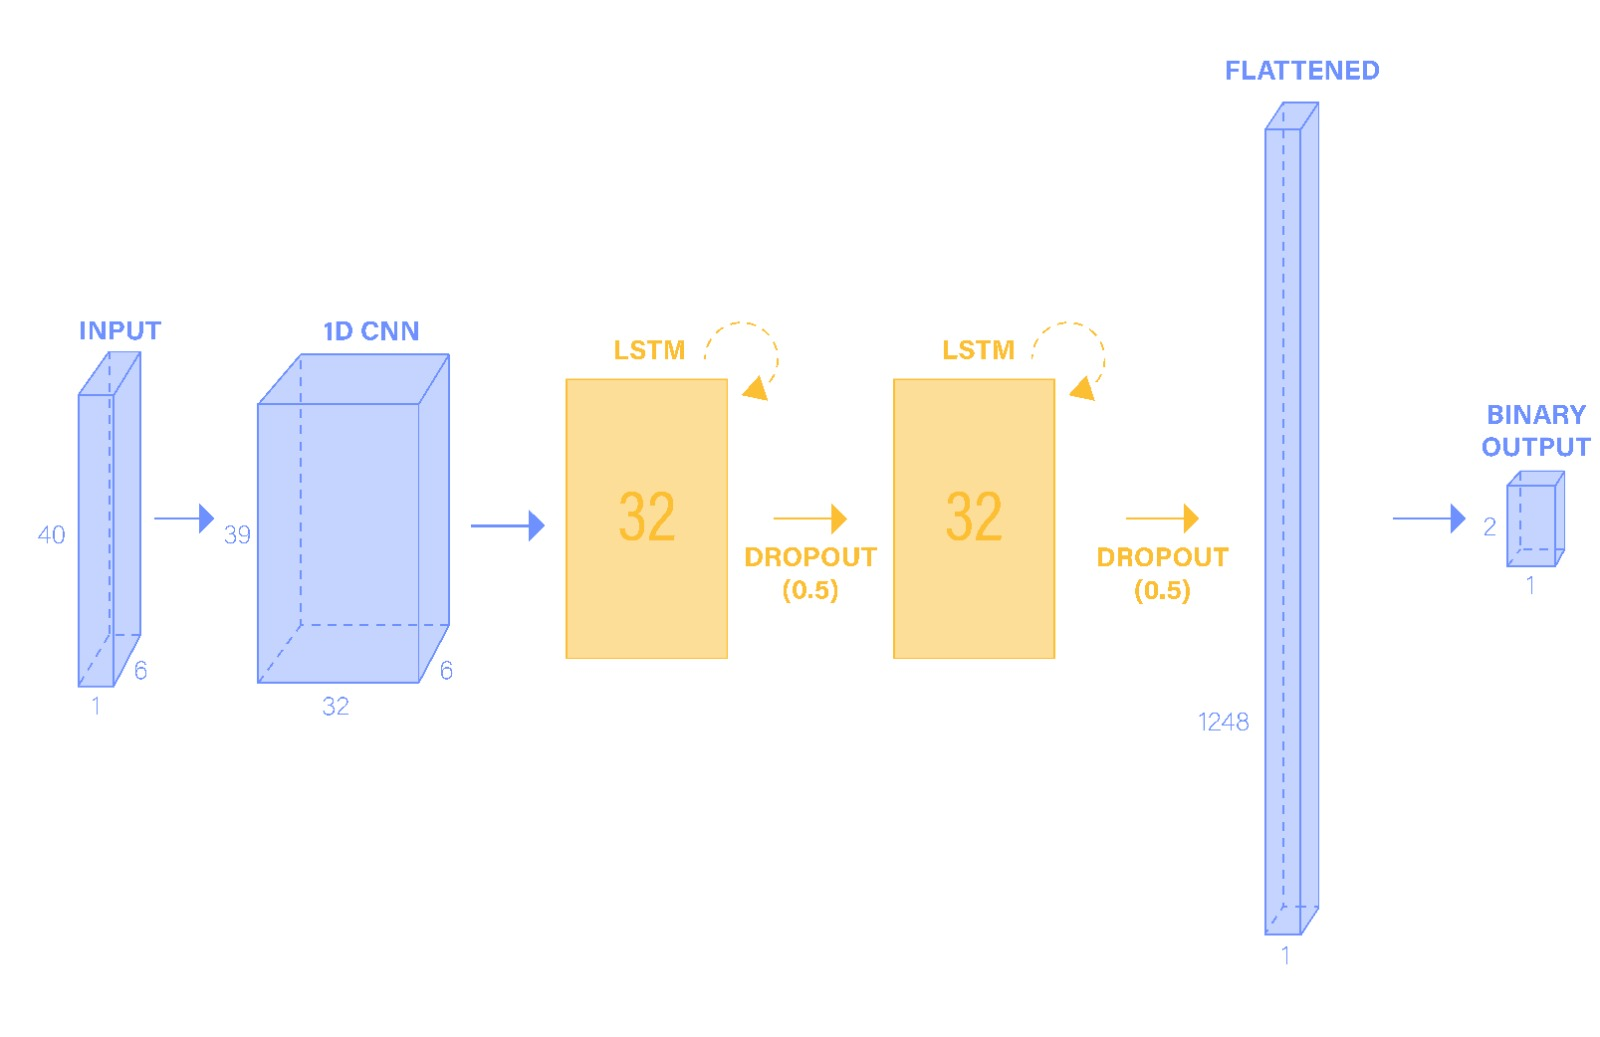

In [1]:
%tensorflow_version 2.x
from sklearn.model_selection import validation_curve
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
import os
import math
from keras.callbacks import LearningRateScheduler
import ast
import h5py

In [2]:
train_data = np.array([])
train_labels = np.array([])
val0_data = np.array([])
val0_labels = np.array([])
val1_data = np.array([])
val1_labels = np.array([])
input_shape = (30,6)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data loading


---

***Description:*** Load the data from a given directory and aplies Sliding window over it with the given size ws.

***Output:*** no returns, load in to the global variables the data from the h5 file.

***Algorithm:*** first we load the rain data from the given h5 file. then we take the first 1000 tupels to be the testing data. for lable 0 and 1 to `val0` and `val1` respectivly.
Then we reshape the data to an array of window where every window is of size ws given to the function.
and we save all the first 1000 in the test variables, bothe data and lables. 

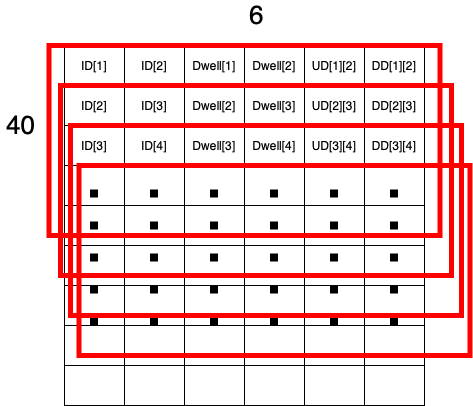

In [4]:
with h5py.File('/content/drive/MyDrive/BioKey/Data_HDF_files/Rand_Dan_WS30.h5','r') as hdf:
  data = hdf.get('train_data')
  train_data = np.array(data)
  data = hdf.get('train_labels')
  train_labels = np.array(data)

In [5]:
for i in range(1000):
  if train_labels[i] == 0:
    val0_data = np.append(val0_data,train_data[i])

val0_labels = np.empty(int(val0_data.shape[0]/(input_shape[0]*6)))
val0_labels.fill(0)

for i in range(1000):
  if train_labels[i] == 1:
    val1_data = np.append(val1_data,train_data[i])

val1_labels = np.empty(int(val1_data.shape[0]/(input_shape[0]*6)))
val1_labels.fill(1)


val1_data = val1_data.reshape(int(val1_labels.shape[0]),input_shape[0],6)
val0_data = val0_data.reshape(int(val0_labels.shape[0]),input_shape[0],6)

train_data = train_data[1000:]
train_labels = train_labels[1000:]

# Model


---


we have a one 1D conv layer with 32 features and a kernel size of 2 then 2 LSTM layers with 32 units and a dropout of 0.5 after each LSTM layer.
At the end we have a fully connected flatten layer and a 2 neurons layer for the clasification with a softmax activation function.

In [6]:
model = keras.models.Sequential()
model.add(layers.Conv1D(32,2,activation='relu', input_shape = input_shape))
model.add(layers.LSTM(32 , return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 32)            416       
                                                                 
 lstm (LSTM)                 (None, 29, 32)            8320      
                                                                 
 dropout (Dropout)           (None, 29, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 29, 32)            8320      
                                                                 
 dropout_1 (Dropout)         (None, 29, 32)            0         
                                                                 
 flatten (Flatten)           (None, 928)               0         
                                                                 
 dense (Dense)               (None, 2)                 1

The Adam optimizer was best fit for our clasification job so we chose him.
we initialized the learning rate to be 0 because as we will see we used a changing learning rate scedual so the initialization of the learning rate should be 0. 

In [7]:
from keras.backend import binary_crossentropy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.0)
metrics = ["accuracy"]

Batch size of 32 was the best performing batch size that we tride between 8 and 128.
The number of epochs is 150 because in this number we reach saturation and there is no point in continuing to teach the model.

In [8]:
model.compile(loss=loss, optimizer=optim,metrics=metrics)
batchSize = 32
epochs = 150

As explaind above we used a learning decay so the initial learning rate is 0.0001,
and at the 100th epoch we derive the learning rate by 10 to be 0.00001. 

In [9]:
def step_decay(epoch):
	initial_lrate = 0.0001
	drop = 0.1
	epochs_drop = 100.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [10]:
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

# Training


---

We split our data in ration of 9:1 witch means that 90% of the data goes to the training process and 10% goes to the validation process.
this way we can better analize the learning stage of our models.

In [11]:
with tf.device('/device:GPU:0'):
  model.fit(train_data,train_labels,batch_size = batchSize ,validation_split = 0.1, callbacks=callbacks_list,epochs=epochs,shuffle=True)

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


983/983 [==============================] - 17s 11ms/step - loss: 0.4136 - accuracy: 0.7933 - val_loss: 0.2895 - val_accuracy: 0.8670 - lr: 1.0000e-04
Epoch 2/150
983/983 [==============================] - 12s 12ms/step - loss: 0.2725 - accuracy: 0.8830 - val_loss: 0.2557 - val_accuracy: 0.8876 - lr: 1.0000e-04
Epoch 3/150
983/983 [==============================] - 10s 11ms/step - loss: 0.2312 - accuracy: 0.9032 - val_loss: 0.2121 - val_accuracy: 0.9156 - lr: 1.0000e-04
Epoch 4/150
983/983 [==============================] - 9s 9ms/step - loss: 0.1998 - accuracy: 0.9185 - val_loss: 0.1906 - val_accuracy: 0.9256 - lr: 1.0000e-04
Epoch 5/150
983/983 [==============================] - 10s 10ms/step - loss: 0.1819 - accuracy: 0.9267 - val_loss: 0.2171 - val_accuracy: 0.9144 - lr: 1.0000e-04
Epoch 6/150
983/983 [==============================] - 12s 12ms/step - loss: 0.1683 - accuracy: 0.9336 - val_loss: 0.1811 - val_accuracy: 0.9293 - lr: 1.0000e-04
Epoch 7/150
983/983 [=====================

# Evaluation

---

In this stage we will test and evaluate the model on an unseen data.
this data in a small portion of our data and it consist of data that is labeled 1 and 0.

Here we are testing the model on the data that is labeled 1 and we can see the accuracy of the model in the predicion process.

In [12]:
model.evaluate(val1_data,val1_labels,batch_size=batchSize, verbose = 1)

probability_model = keras.models.Sequential([
    model,keras.layers.Softmax()
])

predictions = probability_model(val1_data)

pre0 = predictions[0]

print(pre0)

label0 = np.argmax(pre0)

print(label0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


12/12 [==============================] - 1s 5ms/step - loss: 0.0047 - accuracy: 1.0000
tf.Tensor([0.26894176 0.73105824], shape=(2,), dtype=float32)
1


Here we are testing the model on the data that is labeled 0 and we can see the accuracy of the model in the predicion process.

In [13]:
model.evaluate(val0_data,val0_labels,batch_size=batchSize, verbose = 1)

probability_model = keras.models.Sequential([
    model,keras.layers.Softmax()
])

predictions = probability_model(val0_data)

pre0 = predictions[0]

print(pre0)

label0 = np.argmax(pre0)

print(label0)

20/20 [==============================] - 0s 5ms/step - loss: 0.0181 - accuracy: 0.9920
tf.Tensor([0.73105854 0.26894143], shape=(2,), dtype=float32)
0


Saving the model in h5 format. 

In [16]:
model.save("1D_2XLSTM32_1x1_Dan_150epochs_WS30.h5")